In [3]:
import os
import re
import pandas as pd
import numpy as np
from tiled.client import from_uri
from tqdm import tqdm
from numpy.typing import ArrayLike
from scipy.signal import find_peaks

from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

In [4]:
def parse_linescan_log(file_path):
    """
    Parse a linescan log file into a pandas DataFrame.
    
    Each entry in the file should consist of 4 lines:
      1. Timestamp (e.g., "2024-02-12T09-33-05")
      2. Mode (e.g., "mode = xafs_x/It")
      3. UID   (e.g., "uid = e9979416-fd6d-4ea5-9d56-2257f52c9572")
      4. Position (e.g., "position = 144.1771555806452")
    
    The resulting DataFrame uses the UID as the index and includes:
      - timestamp
      - motor (parsed from mode)
      - detector (parsed from mode)
      - position
    """
    data = []
    
    with open(file_path, 'r') as f:
        # Remove blank lines and strip whitespace
        lines = [line.strip() for line in f if line.strip()]
    
    # Process entries in blocks of 4 lines.
    for i in range(0, len(lines), 4):
        try:
            ts_line = lines[i]
            mode_line = lines[i + 1]
            uid_line = lines[i + 2]
            pos_line = lines[i + 3]
        except IndexError:
            # If there are incomplete blocks at the end, skip them.
            break

        # Parse timestamp
        timestamp = ts_line
        
        # Parse mode and split into motor and detector.
        # e.g., "mode = xafs_x/It"
        mode_value = mode_line.split("=", 1)[1].strip()
        motor, detector = mode_value.split("/", 1)
        
        # Parse UID (e.g., "uid = e9979416-fd6d-4ea5-9d56-2257f52c9572")
        uid = uid_line.split("=", 1)[1].strip()
        
        # Parse position (e.g., "position = 144.1771555806452")
        position = float(pos_line.split("=", 1)[1].strip())
        
        data.append({
            "timestamp": timestamp,
            "motor": motor,
            "detector": detector,
            "position": position,
            "uid": uid
        })
    
    df = pd.DataFrame(data)
    df.set_index("uid", inplace=True)
    return df

# Example usage:
# df = parse_linescan_log("path/to/linescan_evaluation.txt.1")
# print(df)


In [5]:
def get_tiled_dataframe(catalog, row: pd.Series) -> tuple[ArrayLike, ArrayLike]:
    """
    Connect to the BMM Tiled catalog, fetch the record corresponding to the given UID,
    and return a DataFrame with all of the relevant primary data.
    
    The function does the following:
      1. Connects to the Tiled server.
      2. Accesses the 'bmm' catalog and retrieves the 'raw' collection.
      3. Uses the UID to fetch the corresponding record.
      4. Reads the primary data (an xarray Dataset) from the record.
      5. Converts the xarray Dataset to a Pandas DataFrame.
    
    Parameters:
        uid (str): The unique identifier of the scan record.
    
    Returns:
        pd.DataFrame: A DataFrame containing the data variables and coordinates
                      from the record’s primary stream.
    
    Example:
        df = get_tiled_dataframe('3b5dc5fa-9252-43cc-b70d-8288f03dbb69')
        print(df.head())
    """
    
    # Retrieve the record using the provided UID
    try:
        record = catalog[row.name]
    except KeyError:
        raise ValueError(f"Record with UID {row.name} not found in the catalog.")
    
    # Read the primary data from the record (an xarray.Dataset)
    ds = record["primary"]["data"]
    try:
        xax = ds[row.motor].read()
    except KeyError:
        print(f"WARNING: UID {row.name} failed to find motor {row.motor} from tiled dataset.")
        return None, None

    # Extract the y data.
    if "Xs" not in row.detector:
        try:
            yax = ds[row.detector]
        except KeyError:
            print(f"WARNING: UID {row.name} failed to find detector {row.detector} from tiled dataset.")
            yax = None
    else:
        # For "Xs", sum channels that match a pattern like "La1", "La2", etc.
        channel_keys = [key for key in ds.keys() if re.match(r'^[A-Z][a-z]?[1-9]$', key)]
        if not channel_keys:
            raise KeyError(f"No channel keys found for 'Xs' mode: {list(ds.keys())}.")
        yax = sum(ds[key].read() for key in channel_keys)
    
    return xax, yax


In [6]:
from typing import Generator
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

def generate_plots(x_arrays: list[ArrayLike], y_arrays: list[ArrayLike], rows: list[pd.Series], preds: list[float] | None = None,  show_optimal: bool=False, show_pred: bool=False) -> Generator:
    """
    Generate a sequence of matplotlib plots without displaying them.
    
    Parameters:
    - x_arrays: list of arrays/lists for the x-axis data.
    - y_arrays: list of arrays/lists for the y-axis data.
    
    Both lists must have the same length, and each corresponding pair of arrays must be of equal length.
    
    Yields:
    - (fig, ax): Tuple containing the matplotlib figure and axis objects for each plot.
    """
    if len(x_arrays) != len(y_arrays):
        raise ValueError("x_arrays and y_arrays must be of the same length.")

    for i, (x, y, row) in enumerate(zip(x_arrays, y_arrays, rows)):
        if len(x) != len(y):
            raise ValueError("Each pair of x and y arrays must be of the same length.")
        fig, ax = plt.subplots()
        ax.plot(x, y)
        if show_optimal:
            ax.axvline(row.position, c="red")
        if show_pred and preds is not None:
            ax.axvline(preds[i], c="green")
        ax.set_title(f"{row.name}: Scanning motor {row.motor} for detector {row.detector}")
        ax.set_ylabel(row.detector)
        ax.set_xlabel(row.motor)
        yield fig, ax

    
def show_plots(x_arrays: list[ArrayLike], y_arrays: list[ArrayLike], rows: list[pd.Series], preds: list[float] | None = None, show_optimal: bool = False, show_pred: bool = False) -> None:
    for fig, _ in generate_plots(x_arrays, y_arrays, rows, preds=preds, show_optimal=show_optimal, show_pred=show_pred):
        fig.show()


def save_plots(x_arrays: list[ArrayLike], y_arrays: list[ArrayLike], rows: list[pd.Series]) -> None:
    for fig, ax in generate_plots(x_arrays, y_arrays, rows):
        ...

In [7]:
def tune_peak_finder(test_dataset, prominence_values, width_values):
    """
    Tunes the 'prominence' and 'width' parameters of find_highest_peak_position by
    minimizing the average mean squared error (MSE) between the predicted and the 
    true peak positions on a test dataset.
    
    Parameters
    ----------
    test_dataset : list of tuples
        Each tuple should be (x_array, y_array, true_peak_x), where:
            - x_array: array-like, positions scanned (e.g., motor positions)
            - y_array: array-like, corresponding measured signal values
            - true_peak_x: float, the known (ground-truth) x-position of the peak.
    prominence_values : list or array-like
        A list of candidate values for the 'prominence' parameter.
    width_values : list or array-like
        A list of candidate values for the 'width' parameter.
    
    Returns
    -------
    best_params : dict
        A dictionary containing the best 'prominence' and 'width' values.
    best_mse : float
        The lowest average MSE achieved with the best parameters.
    """
    best_mse = np.inf
    best_params = {'prominence': None, 'width': None}
    mse_grid = np.zeros((len(width_values), len(prominence_values)))
    
    # Loop over each candidate combination
    for i, wd in enumerate(width_values):
        for j, prom in tqdm(enumerate(prominence_values)):
            mse_list = []
            for x_data, y_data, true_peak in test_dataset:
                pred_peak, _ = find_highest_peak_position(x_data, y_data, prominence=prom, width=wd)
                # If no peak is found, assign a high penalty error
                if pred_peak is None:
                    mse_list.append(1e6)
                else:
                    mse_list.append((pred_peak - true_peak)**2)
            mse_grid[i, j] = np.mean(mse_list)
            avg_mse = np.mean(mse_list)
            
            # Update best parameters if current combination gives a lower MSE
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params['prominence'] = prom
                best_params['width'] = wd
                
    return best_params, best_mse, mse_grid

def find_highest_peak_position(x, y, prominence=0.01, width=1):
    """
    Find the highest peak in (x, y) data using scipy.signal.find_peaks.
    
    Parameters
    ----------
    x : array-like
        The x-values (e.g., motor positions).
    y : array-like
        The signal values corresponding to each x.
    prominence : float, optional
        Required prominence of peaks.
    width : float, optional
        Required width of peaks.
    
    Returns
    -------
    peak_x : float or None
        The x-value of the highest peak.
    peak_y : float or None
        The y-value of the highest peak.
    """
    peaks, properties = find_peaks(y, prominence=prominence, width=width)
    if len(peaks) == 0:
        return None, None
    max_peak_idx = np.argmax(y[peaks])
    best_peak = peaks[max_peak_idx]
    return x[best_peak], y[best_peak]

def evaluate_params(test_dataset, prom, wd):
    """Evaluate average MSE for a given set of prominence and width."""
    mse_list = []
    for x_data, y_data, true_peak in test_dataset:
        pred_peak, _ = find_highest_peak_position(x_data, y_data, prominence=prom, width=wd)
        if pred_peak is None:
            mse_list.append(1e6)  # High penalty if no peak is found
        else:
            mse_list.append((pred_peak - true_peak)**2)
    return np.mean(mse_list)

def plot_grid_search(test_dataset, prominence_values, width_values, n_jobs=-1):
    """
    Performs a grid search over 'prominence' and 'width' parameters, computes
    the average MSE for each combination in parallel, and plots the grid with a progress bar.
    
    Parameters
    ----------
    test_dataset : list of tuples
        Each tuple is (x_array, y_array, true_peak_x)
    prominence_values : array-like
        Candidate values for 'prominence'
    width_values : array-like
        Candidate values for 'width'
    n_jobs : int, optional
        Number of jobs for parallel processing (-1 uses all available cores)
    """
    mse_grid = np.zeros((len(width_values), len(prominence_values)))
    n_combinations = len(width_values) * len(prominence_values)

    # Use tqdm_joblib to wrap the parallel loop with a progress bar
    with tqdm_joblib(tqdm(total=n_combinations, desc="Evaluating parameter combinations")):
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_params)(test_dataset, prom, wd)
            for wd in width_values
            for prom in prominence_values
        )
    
    # Fill the mse_grid with results
    k = 0
    for i in range(len(width_values)):
        for j in range(len(prominence_values)):
            mse_grid[i, j] = results[k]
            k += 1
    
    # Plot the grid search results as a heatmap
    plt.figure(figsize=(8, 6))
    extent = [prominence_values[0], prominence_values[-1], width_values[0], width_values[-1]]
    im = plt.imshow(mse_grid, origin='lower', extent=extent, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Average MSE')
    plt.xlabel('Prominence')
    plt.ylabel('Width')
    plt.title('Grid Search Results for Peak Finder Tuning')
    plt.show()
    return mse_grid

In [8]:
df1 = parse_linescan_log(os.path.join("datasets", "linescan_evaluation.txt.1"))
df2 = parse_linescan_log(os.path.join("datasets", "linescan_evaluation.txt.2"))
df = pd.concat([df1, df2], axis=0)
df.head()

,timestamp,motor,detector,position
uid,,,,
e9979416-fd6d-4ea5-9d56-2257f52c9572,2024-02-12T09-33-05,xafs_x,It,144.177156
2d8b6741-e589-4e6b-8c16-f3ab6bbc336e,2024-02-12T09-36-20,xafs_x,It,144.150454
2e30454f-a5ac-48f9-a3bf-5e1b15e544b5,2024-02-12T09-40-38,xafs_x,It,143.644743
a925e08a-7d1c-4e44-a8d5-126bcb62dc9e,2024-02-12T09-45-30,xafs_x,It,144.097048
76c348a3-5bb4-4b21-93e6-9e25995c6eaf,2024-02-12T09-48-23,xafs_x,It,141.169582


In [9]:
# Connect to the Tiled server
container = from_uri('https://tiled.nsls2.bnl.gov')
# Access the 'bmm' catalog, specifically the 'raw' collection
bmm_catalog = container['bmm']['raw']

In [18]:
x_arrays = []
y_arrays = []
rows = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    xax, yax = get_tiled_dataframe(bmm_catalog, row)
    x_arrays.append(xax)
    y_arrays.append(yax)
    rows.append(row)

100%|██████████| 2511/2511 [07:27<00:00,  5.61it/s]


In [ ]:
optimal_positions = [r.position for r in rows]
prominence_values = np.linspace(0.01, 0.2, 10)
width_values = np.linspace(0.5, 5, 10)
mse_grid = plot_grid_search(list(zip(x_arrays, y_arrays, optimal_positions)), prominence_values, width_values, n_jobs=4)

Evaluating parameter combinations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
best_width, best_prom = np.unravel_index(np.argmax(mse_grid), mse_grid.shape)

In [ ]:
start = 10
stop = 50
scipy_preds = []
for x, y in zip(x_arrays, y_arrays)[start:stop]:
    pred = find_highest_peak_position(x, y, best_prom, best_width)[0]
    scipy_preds.append(pred)

/tmp/ipykernel_47569/87768565.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


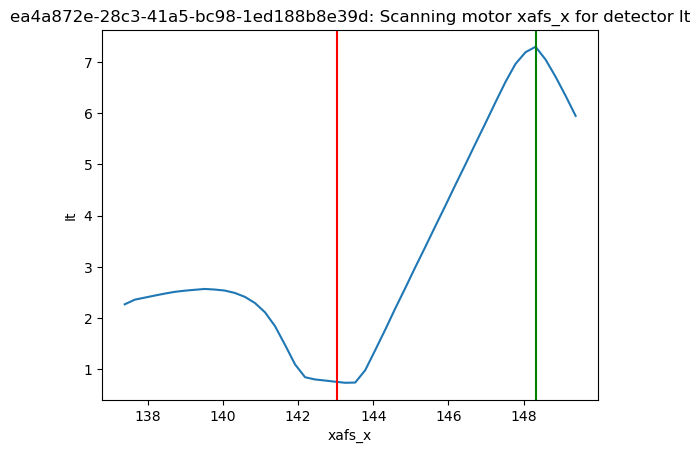

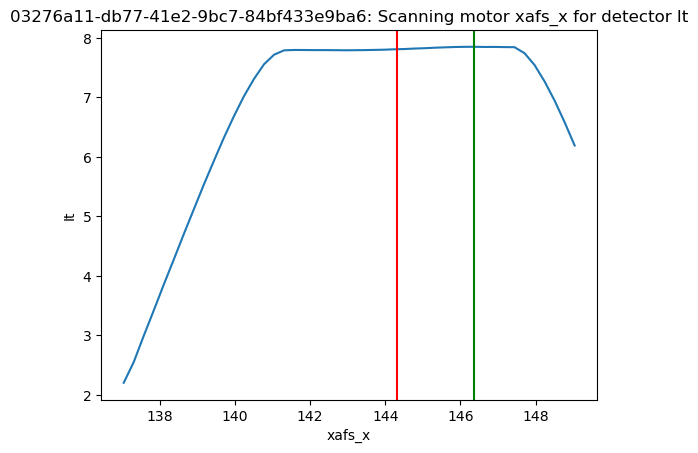

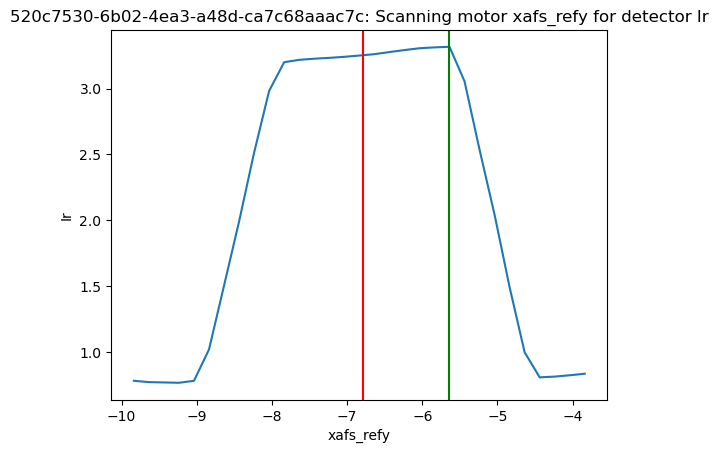

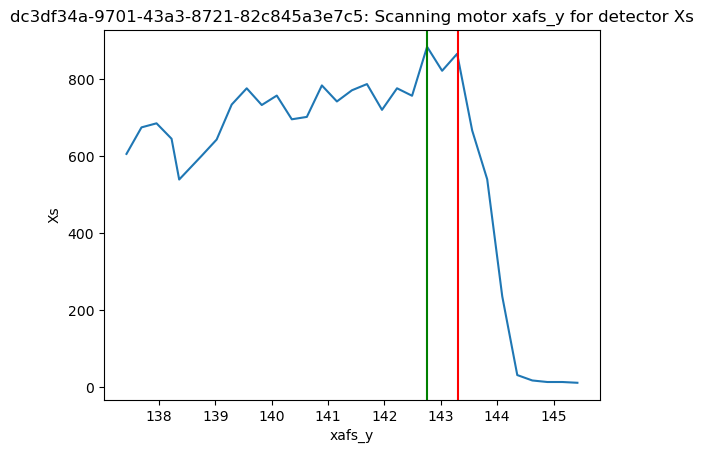

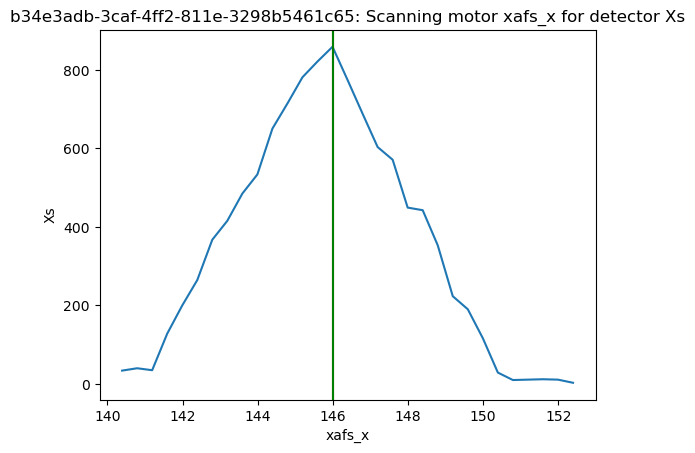

In [ ]:
show_plots(x_arrays[start:stop], y_arrays[start:stop], rows[start:stop], preds=scipy_preds, show_optimal=True, show_pred=True)

In [ ]:
df = pd.read_csv("gpt_responses.csv", index_col="uid")
eval_df = df.dropna()
mse = ((eval_df.position - eval_df.response) ** 2).mean()
mse

nan

In [ ]:
pred_df = pd.DataFrame(rows)
df2 = pd.concat((df, pred_df), axis=0).loc[:, ("position",)].reset_index().rename(columns={"index": "uid"})
df2["response"] = np.nan
df2.to_csv("gpt_responses.csv", index=False)

/tmp/ipykernel_43628/2643602172.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


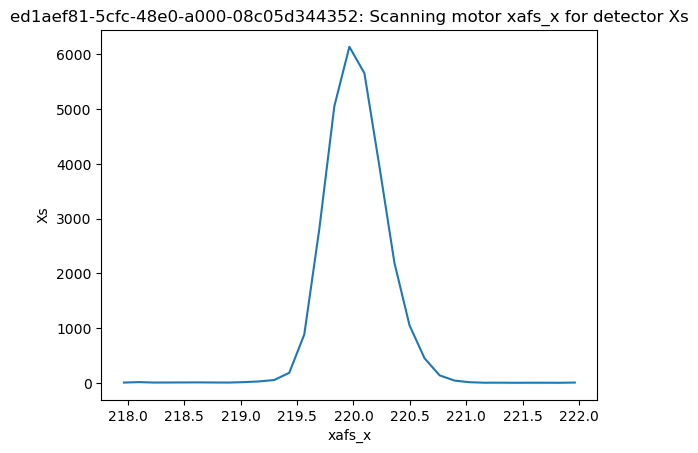

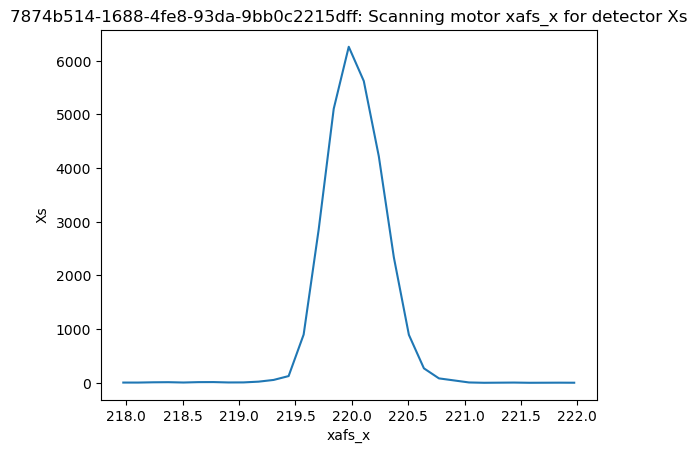

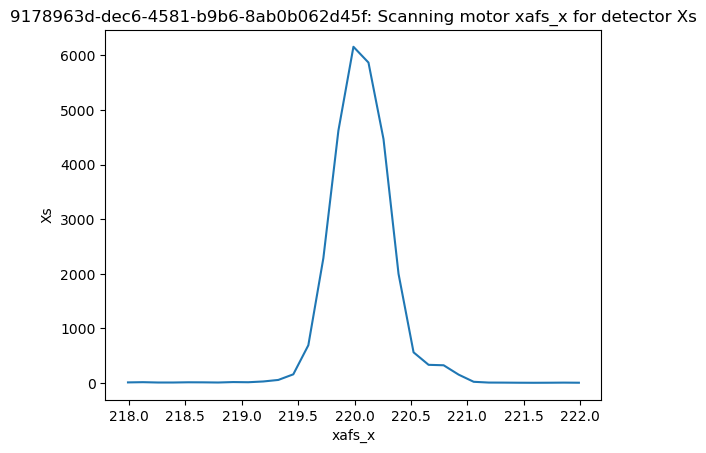

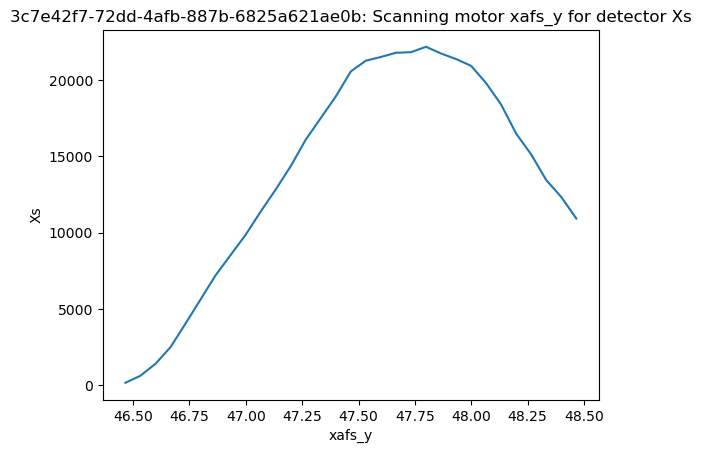

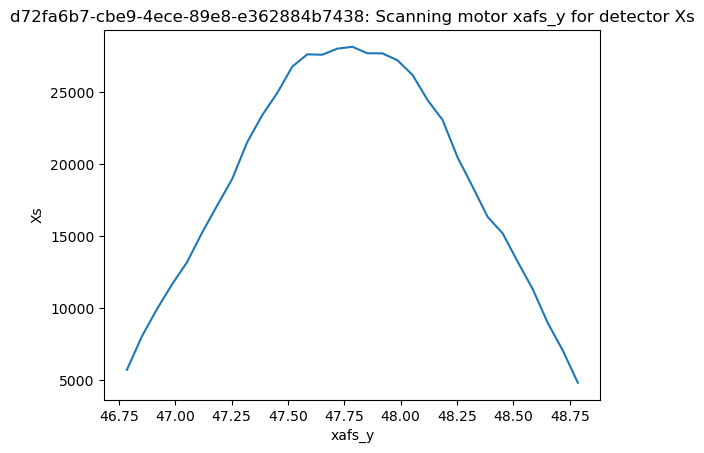

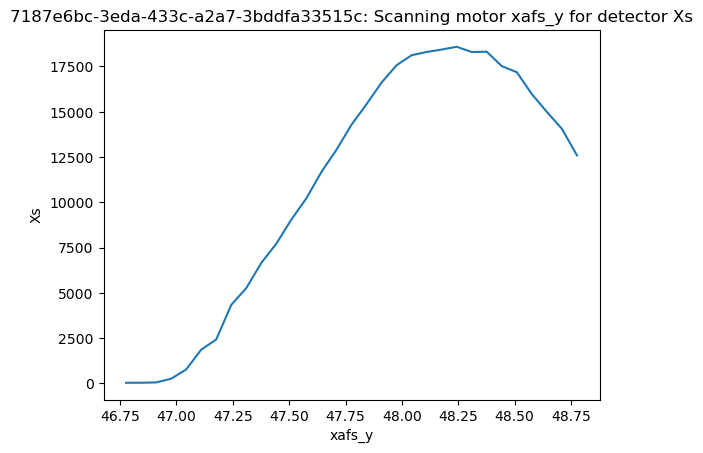

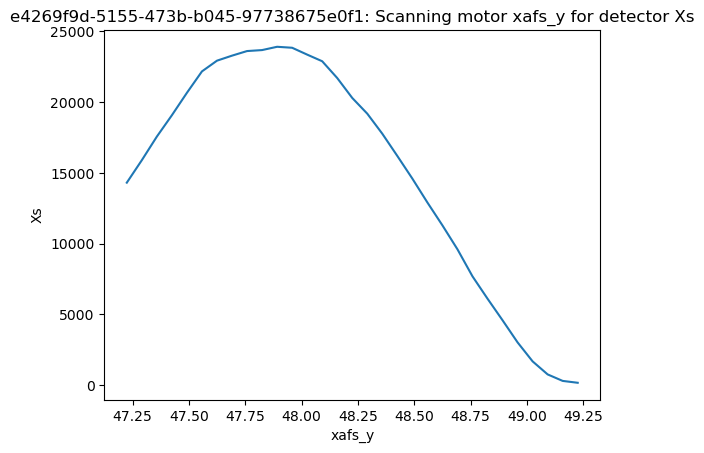

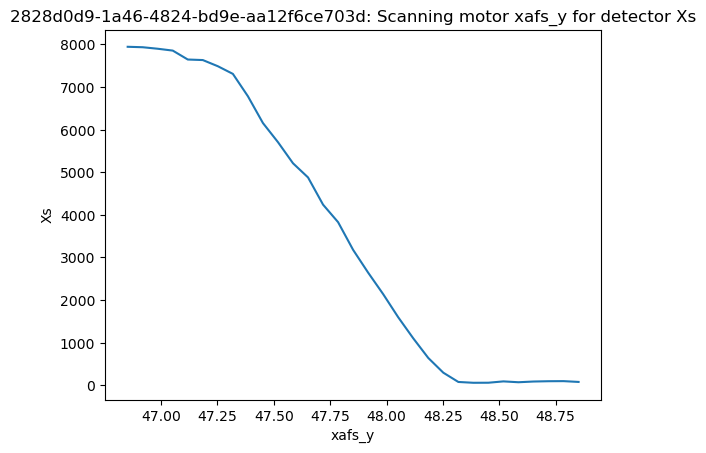

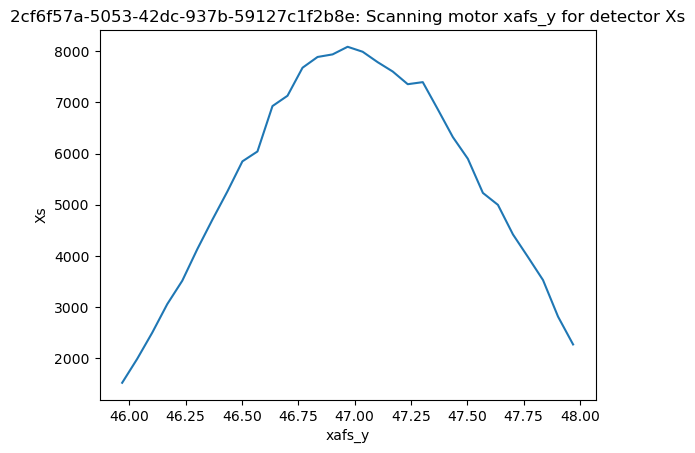

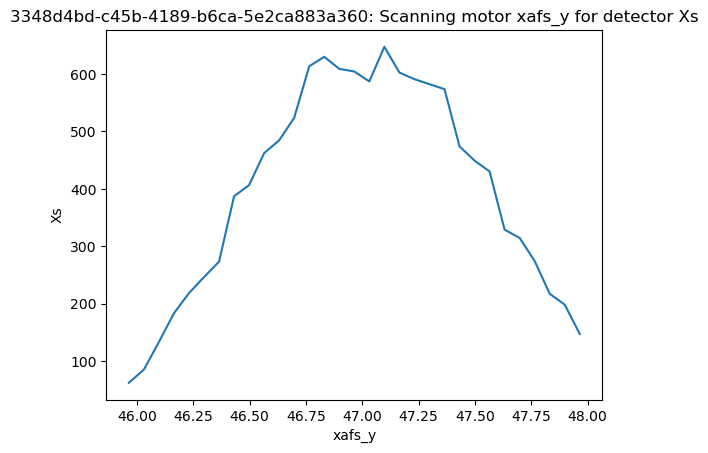

In [ ]:
show_plots(x_arrays, y_arrays, rows)